## Subword Tokenization

In [1]:
from transformers import AutoTokenizer
from transformers import DistilBertTokenizer

In [2]:
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

distilbert_tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)

In [3]:
# “ ”
text = "Tokenizing text is a core task of NLP."

In [4]:
# Tokenize the text
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [5]:
# Convert the token ids to tokens
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]']


In [6]:
# Convert tokens to string
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenizing text is a core task of nlp. [SEP]


In [7]:
dir(tokenizer)[-25:]

['prepare_seq2seq_batch',
 'pretrained_init_configuration',
 'pretrained_vocab_files_map',
 'push_to_hub',
 'register_for_auto_class',
 'sanitize_special_tokens',
 'save_pretrained',
 'save_vocabulary',
 'sep_token',
 'sep_token_id',
 'set_truncation_and_padding',
 'slow_tokenizer_class',
 'special_tokens_map',
 'special_tokens_map_extended',
 'split_special_tokens',
 'tokenize',
 'train_new_from_iterator',
 'truncate_sequences',
 'truncation_side',
 'unk_token',
 'unk_token_id',
 'verbose',
 'vocab',
 'vocab_files_names',
 'vocab_size']

In [8]:
print(tokenizer.vocab_size)
print(tokenizer.model_max_length)

30522
512


## Tokenizing the Whole Dataset

In [9]:
import datasets

In [10]:
emotions = datasets.load_dataset("emotion")

In [11]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

"""
This function applies the tokenizer to a batch of examples; padding=True will pad the
examples with zeros to the size of the longest one in a batch, and truncation=True
will truncate the examples to the model’s maximum context size.
"""

'\nThis function applies the tokenizer to a batch of examples; padding=True will pad the\nexamples with zeros to the size of the longest one in a batch, and truncation=True\nwill truncate the examples to the model’s maximum context size.\n'

In [12]:
dir(emotions)
emotions.column_names
emotions['train'][:2]

emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

"""By default, the map() method operates individually on every example in the corpus,
so setting batched=True will encode the tweets in batches. Because we’ve set
batch_size=None, our tokenize() function will be applied on the full dataset as a
single batch. This ensures that the input tensors and attention masks have the same
shape globally, and we can see that this operation has added new input_ids and
attention_mask columns to the dataset:"""

print(emotions_encoded["train"].column_names)

['text', 'label', 'input_ids', 'attention_mask']


# Training a Text Classifier

## Transformers as Feature Extractors

In [13]:
from transformers import AutoModel
import torch

In [14]:
model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

### Extracting the last hidden states

In [15]:
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")
# shape [batch_size, n_tokens]

Input tensor shape: torch.Size([1, 6])


In [16]:
inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad():#  disable the automatic calculation of the gradient
    outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]]), hidden_states=None, attentions=None)


In [17]:
outputs.last_hidden_state.size()

torch.Size([1, 6, 768])

Looking at the hidden state tensor, we see that it has the shape [batch_size,
n_tokens, hidden_dim]. In other words, a 768-dimensional vector is returned for
each of the 6 input tokens.

Now we know how to get the last hidden state for a single string; let’s do the same for
the whole dataset by creating a new hidden_state column that stores all these vectors.

In [18]:
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [19]:
# convert the input_ids and attention_mask columns to the "torch" format
emotions_encoded.set_format("torch",
    columns=["input_ids", "attention_mask", "label"])

# We can then go ahead and extract the hidden states across all splits in one go:
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

### Creating a feature matrix

In [20]:
import numpy as np

X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

### Visualizing the training set

In [21]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

,X,Y,label
0,3.951496,6.497087,0
1,-3.407341,5.377623,0
2,5.116546,3.132789,3
3,-2.580394,3.421769,2
4,-3.622933,3.434549,3


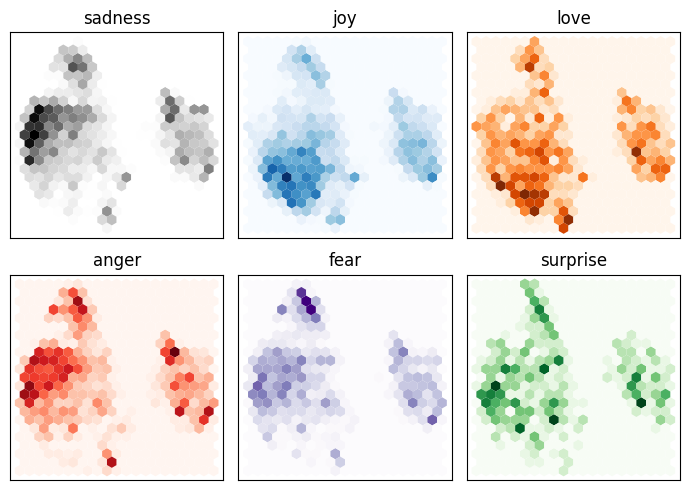

In [22]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names
for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                   gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])
plt.tight_layout()
plt.show()

### Training a simple classifier

In [23]:
from sklearn.linear_model import LogisticRegression


# We increase `max_iter` to guarantee convergence
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.633

In [24]:
from sklearn.dummy import DummyClassifier


# comparing it against a simple baseline
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

So, our simple classifier with DistilBERT embeddings is significantly better than our
baseline.

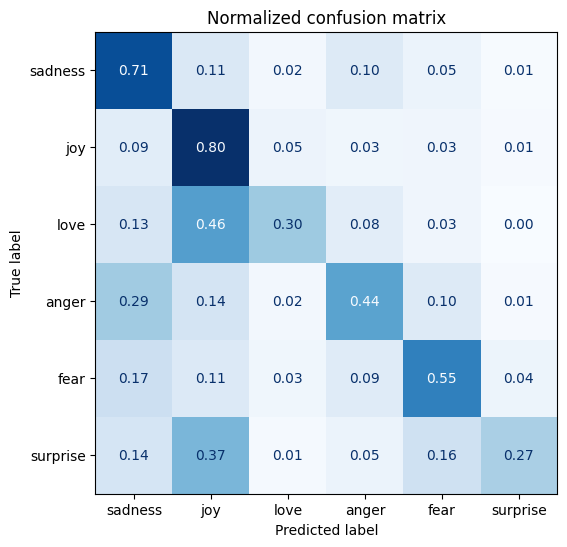

In [25]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()


y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

We can see that anger and fear are most often confused with sadness, which agrees
with the observation we made when visualizing the embeddings. Also, love and
surprise are frequently mistaken for joy.

# Fine-Tuning Transformers

### Loading a pretrained model

Usamos AutoModelForSequenceClassification en vez de AutoModel porque queremos
hacer fine-tuning, en vez de usar el modelo como extractor de features.

In [26]:
from transformers import AutoModelForSequenceClassification

model_ckpt = "distilbert-base-uncased"
num_labels = 6
model = (AutoModelForSequenceClassification
.from_pretrained(model_ckpt, num_labels=num_labels)
.to(device))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Defining the performance metrics

In [27]:
from sklearn.metrics import accuracy_score, f1_score


def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

### Training the model

https://huggingface.co/docs/hub/security#user-access-tokens

In [28]:
from huggingface_hub import notebook_login

notebook_login()

In [29]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True,
                                  log_level="error")

In [30]:
trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train()

  0%|          | 0/500 [00:00<?, ?it/s]

KeyboardInterrupt: 